# Lung Cancer Classification
## By: Karim Zakir

In this notebook, I will be building a classification model, which will help predict whether an individual has lung cancer or not. The dataset that I will be using was obtained from [Kaggle](https://www.kaggle.com/mysarahmadbhat/lung-cancer).

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
cancer = pd.read_csv("datasets/lung_cancer.csv")
cancer.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [3]:
cancer.shape

(309, 16)

In [4]:
cancer.dtypes

GENDER                   object
AGE                       int64
SMOKING                   int64
YELLOW_FINGERS            int64
ANXIETY                   int64
PEER_PRESSURE             int64
CHRONIC DISEASE           int64
FATIGUE                   int64
ALLERGY                   int64
WHEEZING                  int64
ALCOHOL CONSUMING         int64
COUGHING                  int64
SHORTNESS OF BREATH       int64
SWALLOWING DIFFICULTY     int64
CHEST PAIN                int64
LUNG_CANCER              object
dtype: object

In [5]:
to_modify = cancer.columns[2:len(cancer.columns) - 1]
cancer[to_modify] = cancer[to_modify] - 1

In [6]:
target = "LUNG_CANCER"
cancer[target] = (cancer[target] == "YES").astype(int)

In [7]:
oh_encoder = OneHotEncoder()
encoded_cols = pd.DataFrame(oh_encoder.fit_transform(cancer[["GENDER"]]).toarray(), columns=["FEMALE", "MALE"])
encoded_cols.index = cancer.index
cancer = pd.concat([encoded_cols, cancer], axis=1).drop("GENDER", axis=1)

In [8]:
cols_with_missing = [col for col in cancer.columns if cancer[col].isnull().any()]
cols_with_missing

[]

<AxesSubplot:xlabel='LUNG_CANCER', ylabel='count'>

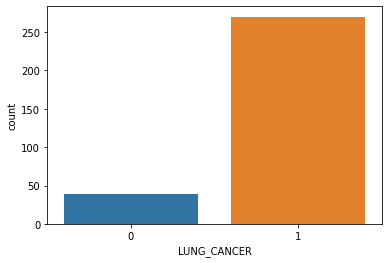

In [9]:
sns.countplot(x="LUNG_CANCER", data=cancer)

In [10]:
value_counts = cancer["LUNG_CANCER"].value_counts()
prop_0 = value_counts[0] / len(cancer)
prop_1 = 1 - prop_0
print(f"Class 0: {prop_0 * 100}% of the dataset")
print(f"Class 1: {prop_1 * 100}% of the dataset")

Class 0: 12.62135922330097% of the dataset
Class 1: 87.37864077669903% of the dataset


Since our classes are quite imbalanced, we need to make sure we stratify our split when we split the data into training and testing data. Since we don't have too many observations (only 309), we won't be using a validation set. 

In [11]:
features = cancer.columns[0: len(cancer.columns) - 1]
X = cancer[features]
y = cancer[target]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

We will start off with a basic logistic regression classification model to get a baseline score and aim to improve on this score throughout the notebook. Note that, since our dataset is quite small, we will be using a liblinear solver, as recommended in [scikit-learn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [14]:
lr_model = LogisticRegression(solver="liblinear")
lr_model.fit(X_train, y_train)
predictions = lr_model.predict(X_test)
accuracy_score(predictions, y_test)

0.8709677419354839

A decent result right off the bat, but since this is a classification task, we can't just rely on the raw accuracy score, so we will also measure the precision/recall for each of the classes to better understand the performance of our model.

In [15]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.90      0.96      0.93        54

    accuracy                           0.87        62
   macro avg       0.70      0.61      0.63        62
weighted avg       0.85      0.87      0.85        62



As suspected, due to the imbalance that is present in our dataset, our recall rate for the 0th class is only 0.25, meaning only one in four observations in class 0 actually get labeled with class 0 by our model. Instead, our recall for class 1 is incredibly high, 0.96. In the real world, this would be a desired result, because, in this particular task, false positives are much less problematic than false negatives, because diagnosing someone cancerless when they don't have cancer is more "safe" than diagnosing someone as without cancer when they do have cancer. However, let's pretend (for the sake of practice) that a hospital that we are working for has incredibly limited capacity for patients with lung cancer. This will make us strive for higher precision in class 1 and higher recall in class 0. Likewise, we should also try and strive for high precision in class 0, since we don't want to miss any people who have cancer. Let's start by working with the data. In particular, we will try to fix the data imbalance in our training data using data augmentation.

We could consider oversampling or undersampling in order to achieve a more balanced dataset; however, neither of these methods are appropriate in this situation in my opinion. Firstly, undersampling of class 1 will lead us to lose a lot of data; since we already don't have many observations in the training dataset, we will be risking a lot of valuable data, which most-likely will greatly decrease the performance of our model. Secondly, oversampling of class 0 will most-likely cause overfitting of our model, because of how large the imbalance is. This will lead to a worse performance in the testing dataset and the real-world in general. We could consider these options if the imbalance was about 60-40, but these methods are simply not viable options when our dataset has an imbalance of 88-12.

Consequently, we will be using data augmentation to decrease the imbalance, meaning we will create new synthetic data points based on our existing data points. In particular, I will be using SMOTE and ADASYN and determine which method is better for our particular case. I will be using `imblearn`'s implemenation of these two algorithms.

Note that the difference between SMOTE and ADASYN is that ADASYN augments points, which are 'harder' to classify i.e. they are close to the points from a different class. Based on these differences in the algorithms, one algorithm might be able to perform better than another.

In [40]:
sm = SMOTE(random_state=0)
sm_X, sm_y = sm.fit_resample(X_train, y_train)

In [41]:
ada = ADASYN(random_state=0)
ada_X, ada_y = ada.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'ADASYN')

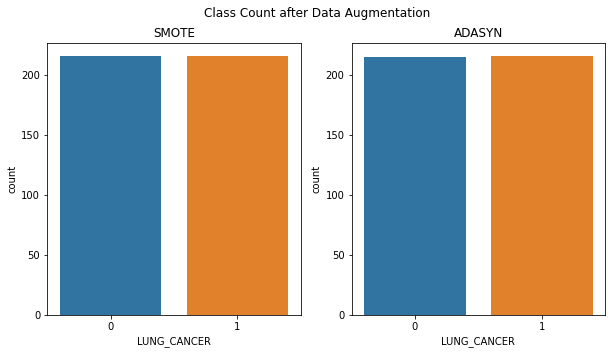

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Class Count after Data Augmentation")
sns.countplot(ax=axes[0], x=sm_y).set_title("SMOTE")
sns.countplot(ax=axes[1], x=ada_y).set_title("ADASYN")

Now that our training dataset is balanced, we will see if that increases our performance by testing on the logistic regression model again.

In [43]:
sm_model = LogisticRegression(solver="liblinear")
sm_model.fit(sm_X, sm_y)
predictions = sm_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(classification_report(y_test, predictions))

Accuracy: 0.9032258064516129
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.93      0.96      0.95        54

    accuracy                           0.90        62
   macro avg       0.80      0.73      0.76        62
weighted avg       0.89      0.90      0.90        62



This is an excellent result! We increased our overall accuracy and precision in both the classes, and increased our recall in class 0, which is what we aimed for. Additionally, this increase in performance didn't come as a trade-off for recall in class 1, which is ideal! Let's now check if this is the case for ADASYN.

In [49]:
ada_model = LogisticRegression(solver="liblinear")
ada_model.fit(ada_X, ada_y)
predictions = ada_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(classification_report(y_test, predictions))

Accuracy: 0.8870967741935484
              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.93      0.94      0.94        54

    accuracy                           0.89        62
   macro avg       0.75      0.72      0.73        62
weighted avg       0.88      0.89      0.88        62



With ADASYN, our model got closer to what we wanted, but, nevertheless, the precision of class 0 and recall for class 1 is higher when the model is trained with SMOTE and not ADASYN; this causes the overall accuracy to be higher for SMOTE. As such, we will continue to be using the dataset augmented using SMOTE within this notebook. 

Let's now move on to the next stage of our investigation and attempt to pick a set of classification models that we will hyperparameterize to improve the score further. We will use the following models at this stage:
- Logistic Regression
- RBF SVM
- Linear SVM
- KNearestNeighbors
- RandomForest
- MLPClassifier (Multi-Layers Percepetron Classifier)
- Gaussian Naive Bayes

Out of these 6 models, we will pick the top 3 and continue optimizing them

In [50]:
models_dict = {"Logistic Regression": LogisticRegression(solver="liblinear"),
               "RBF Support Vector Machine": SVC(),
               "Linear Support Vector Machine": SVC(kernel="linear"),
               "K-Nearest Neighbors": KNeighborsClassifier(),
               "Random Forest": RandomForestClassifier(random_state=0),
               "Multi-Layer Perceptron": MLPClassifier(max_iter=500, random_state=0),
               "Gaussian Naive Bayes": GaussianNB()}
scores_dict = {}
clf_reports = {}
for name, model in models_dict.items():
    model.fit(sm_X, sm_y)
    predictions = model.predict(X_test)
    scores_dict[name] = accuracy_score(y_test, predictions)
    clf_reports[name] = classification_report(y_test, predictions, output_dict=True)

scores = sorted(scores_dict.items(), key=lambda x: x[1], reverse=True)

for name, score in scores[:3]:
    print(f"{name}: {score}")

Linear Support Vector Machine: 0.9193548387096774
Logistic Regression: 0.9032258064516129
K-Nearest Neighbors: 0.9032258064516129


We can see that our top three models are a Linear Support Vector Machine, Logistic Regression, and K-Nearest Neighbors. So, these are the three models that we will focus for the remainder of this investigation. Let's get more insight into the performance of these models by looking at their classification reports. To make the side-by-side comparison easier, we will visualize the reports.

In [51]:
lsvm_report = clf_reports["Linear Support Vector Machine"]
lr_report = clf_reports["Logistic Regression"]
knn_report = clf_reports["K-Nearest Neighbors"]
top_reports = [lsvm_report, lr_report, knn_report]

In [52]:
class_0_precision = [report['0']["precision"] for report in top_reports]
class_0_recall = [report['0']["recall"] for report in top_reports]
class_1_precision = [report['1']["precision"] for report in top_reports]
class_1_recall = [report['1']["recall"] for report in top_reports]

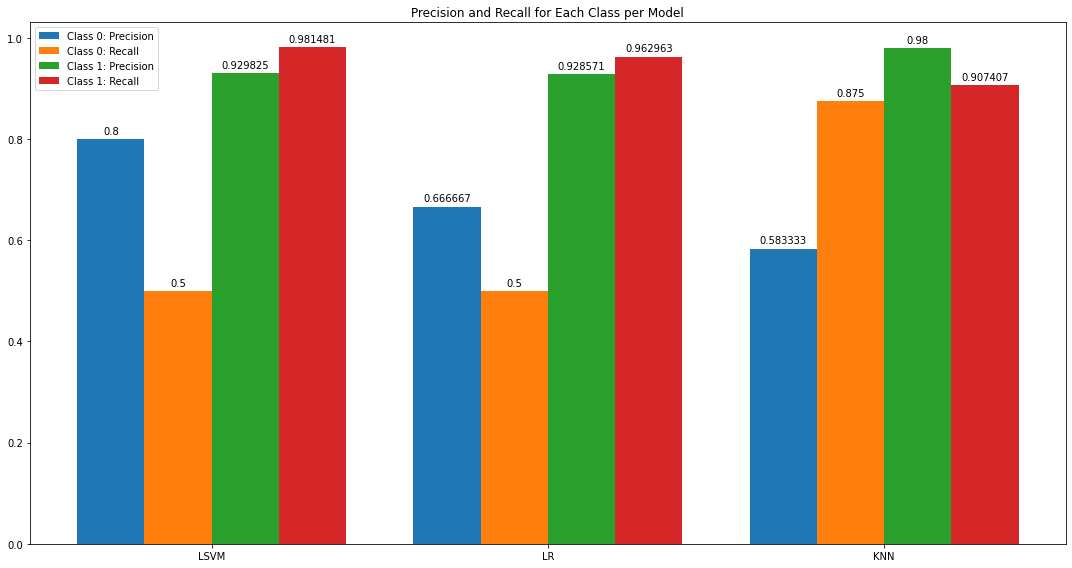

In [53]:
fig, ax = plt.subplots(figsize=(15, 8))
width = 0.2
length = np.arange(3)
class_0_precision_bars = ax.bar(length-1.5*width, class_0_precision, width, label="Class 0: Precision")
class_0_recall_bars = ax.bar(length-width/2, class_0_recall, width, label="Class 0: Recall")
class_1_precision_bars = ax.bar(length+width/2, class_1_precision, width, label="Class 1: Precision")
class_1_recall_bars = ax.bar(length+1.5*width, class_1_recall, width, label="Class 1: Recall")

ax.set_xticks(length)
ax.set_title('Precision and Recall for Each Class per Model')
ax.set_xticklabels(["LSVM", "LR", "KNN"])
ax.legend()

ax.bar_label(class_0_precision_bars, padding=3)
ax.bar_label(class_0_recall_bars, padding=3)
ax.bar_label(class_1_precision_bars, padding=3)
ax.bar_label(class_1_recall_bars, padding=3)


fig.tight_layout()

plt.show()

In this task, we are striving for high class 0 recall and high class 1 precision. Based on the above plot, the model that is the best in these two objectives is the K-Nearest Neighbors model. Although it has lower overall accuracy than the Linear Support Vector Machine, it's currently the best model in terms of what we are looking for specifically. Nevertheless, now, we will hyperparameterize all three models in order to improve their performance further. 

In [54]:
def grid_search_model(model_class, params):
    model = model_class()
    model_grid = GridSearchCV(model, params)
    model_grid.fit(sm_X, sm_y)
    best_params = model_grid.best_params_
    best_model = model_class(**best_params)
    best_model.fit(sm_X, sm_y)
    predictions = best_model.predict(X_test)
    print(f"The best parameters are: {best_params}")
    print(f"Accuracy: {accuracy_score(y_test, predictions)}")
    print(classification_report(y_test, predictions))

In [55]:
c_list = np.array(range(25, 200, 25)) / 100
svc_params = {"C": c_list, "random_state": [0], "kernel":["linear"]}
grid_search_model(SVC, svc_params)

The best parameters are: {'C': 0.5, 'kernel': 'linear', 'random_state': 0}
Accuracy: 0.9032258064516129
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.93      0.96      0.95        54

    accuracy                           0.90        62
   macro avg       0.80      0.73      0.76        62
weighted avg       0.89      0.90      0.90        62



With the best parameters as determined by our GridSearch, we can see that while our precision for class 0 has imrpoved, our precision and recall for class 1 have decreased, decreasing overall accuracy for our linear support vector machine model.

In [57]:
lr_params = {"C": c_list, "penalty": ["l1", "l2"]}
grid_search_model(LogisticRegression, lr_params)

The best parameters are: {'C': 0.5, 'penalty': 'l2'}
Accuracy: 0.9193548387096774
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.95      0.96      0.95        54

    accuracy                           0.92        62
   macro avg       0.83      0.79      0.81        62
weighted avg       0.92      0.92      0.92        62



This time around, we have actually improved the overall performance of our model. Additionally, we have pushed the recall of class 0 higher and improved the precision of class 1, which is what we were striving for in our investigation. This makes this model better for us than our previously best performing linear support vector machine, while having the same overall accuracy.

In [58]:
neighbors_list = np.array(range(3, 11))
leaf_list = np.array(range(24, 42, 2))
knn_params = {"n_neighbors": neighbors_list, "weights": ["uniform", "distance"], "algorithm": ["ball_tree", "kd_tree"],
              "leaf_size": leaf_list}
grid_search_model(KNeighborsClassifier, knn_params)

The best parameters are: {'algorithm': 'ball_tree', 'leaf_size': 24, 'n_neighbors': 3, 'weights': 'distance'}
Accuracy: 0.8870967741935484
              precision    recall  f1-score   support

           0       0.55      0.75      0.63         8
           1       0.96      0.91      0.93        54

    accuracy                           0.89        62
   macro avg       0.75      0.83      0.78        62
weighted avg       0.91      0.89      0.89        62



Unfortunately, using GridSearchCV, we found a worse performing model than our original KNN model. Compared to our previous instance of KNN model, the newer model has slightly better recall of class 1, but has worse precision for both class 1 and 0 and worse recall for class 0, making it unsuitable for our investigation. 

Now, we have two models to choose from: our initial SVM-based model and the LR model we obtained from GridSearchCV. Let's plot their detailed accuracies to make comparison easier.

In [59]:
lr_params = {"C": 0.5, "penalty": "l2"}
best_lr = LogisticRegression(**lr_params)
best_lr.fit(sm_X, sm_y)
predictions = best_lr.predict(X_test)
lr_report = classification_report(y_test, predictions, output_dict=True)
latest_reports = [lsvm_report, lr_report]

In [60]:
class_0_precision = [report['0']["precision"] for report in latest_reports]
class_0_recall = [report['0']["recall"] for report in latest_reports]
class_1_precision = [report['1']["precision"] for report in latest_reports]
class_1_recall = [report['1']["recall"] for report in latest_reports]

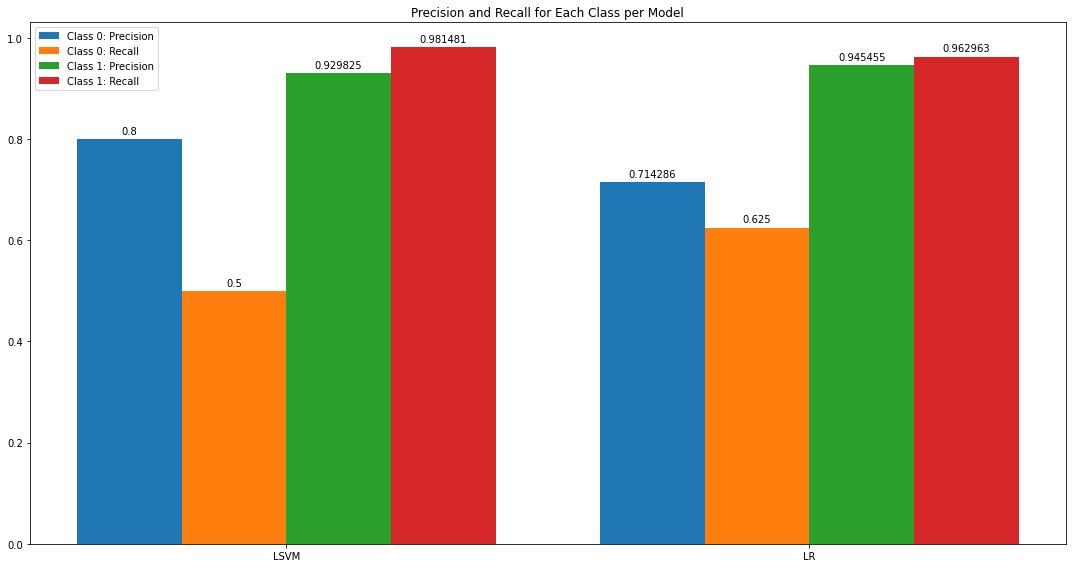

In [61]:
fig, ax = plt.subplots(figsize=(15, 8))
width = 0.2
length = np.arange(2)
class_0_precision_bars = ax.bar(length-1.5*width, class_0_precision, width, label="Class 0: Precision")
class_0_recall_bars = ax.bar(length-width/2, class_0_recall, width, label="Class 0: Recall")
class_1_precision_bars = ax.bar(length+width/2, class_1_precision, width, label="Class 1: Precision")
class_1_recall_bars = ax.bar(length+1.5*width, class_1_recall, width, label="Class 1: Recall")

ax.set_xticks(length)
ax.set_title('Precision and Recall for Each Class per Model')
ax.set_xticklabels(["LSVM", "LR"])
ax.legend()

ax.bar_label(class_0_precision_bars, padding=3)
ax.bar_label(class_0_recall_bars, padding=3)
ax.bar_label(class_1_precision_bars, padding=3)
ax.bar_label(class_1_recall_bars, padding=3)


fig.tight_layout()

plt.show()

Our aim for this task is higher recall for class 0 and higher precision for class 1. Both of these metrics are better achieved by our logistic regression model, so that is the model I would recommend the hospital uses when trying to decide whether a patient has cancer or not. However, realistically, we know that false positives are less problematic than false negatives. So, in the real world, my recommendation would be to go with the model that has higher precision for class 0 and high recall for class 1, which in this case is the LSVM model.

Thank you for taking the time to read through this notebook! Would love to hear your feedback. Feel free to open an issue on GitHub. Thanks!